In [1]:
#!/usr/bin/env python
import librosa 
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
# source audio to beat track
audio_file = './audio/nommo_60.wav'
audio_file = './audio/nommoslice.wav'

In [139]:
hop_length = 512 
dur = 10 # 10 seconds
[y,sr] = librosa.load(audio_file, duration=dur, sr=None) # load in audio file
frames = len(y)//hop_length # get num frames
print ('sr: %r, frames: %r samps: %r') %(sr, frames, len(y)) 

# get spectral onset envelope per frame
onset_env = librosa.onset.onset_strength(y=y,sr=sr, hop_length=512, aggregate=np.median)

# autocorrelate
ac = librosa.autocorrelate(onset_env, 2*sr//hop_length)

peaks = librosa.util.peak_pick(onset_env,3,3,3,5,0.5,10)
print('found %r number of peaks') %(len(peaks))


sr: 44100, frames: 861 samps: 441000
found 35 number of peaks


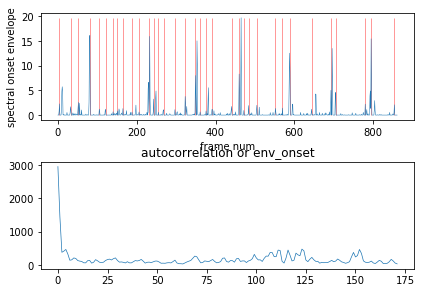

In [4]:
plt.figure() 
plt.subplot(2,1,1) 
plt.plot(onset_env, linewidth='0.5') 
plt.vlines(peaks, 0, onset_env.max(), color='r', alpha=0.8, linewidth='0.5')
plt.xlabel('frame num') 
plt.ylabel('spectral onset envelope') 

plt.axis('tight') 
plt.tight_layout() 

plt.subplot(2,1,2) 
plt.plot(ac, linewidth='0.7')
plt.title('autocorrelation or env_onset')

plt.show() 
plt.close()


862 35
19.7422766954 0.0


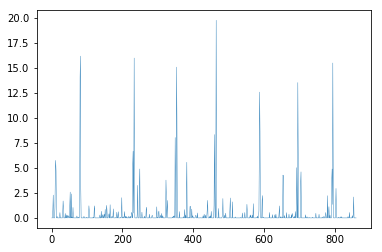

In [155]:
print len(onset_env), len(peaks)
print max(onset_env), min(onset_env)

# set threshold for envelope detection
thresh = 0.0
thresh_onsets = np.copy(onset_env)
thresh_onsets[thresh_onsets < thresh] = 0 # zero out all other onsets

# thresholded onset amplitude array normalized, these are still indexed by FRAME
onset_amps = np.asarray([onset/max(thresh_onsets) for onset in thresh_onsets]) # normalize
onset_amps = onset_amps[peaks] # by frame


# sanity check
plt.figure()
plt.plot(thresh_onsets, linewidth='0.4')
plt.show()


In [135]:
# beatarray = np.array([[0.0,0.2,0,0.99],[33.8,11.0,0,0]])

# # force all non-zero onset values to zero to form binary vector
# beatarray[beatarray>0] = 1 



[ 0.1156537   0.08582367  0.13091659  0.81874041  0.06145322  0.06104582
  0.03370788  0.04326373  0.06684963  0.03126981  0.03205396  0.33742075
  0.16488549  0.0291508   0.05429046  0.05620564  0.19143833  0.40674307
  0.03215936  0.04236897  0.05941489  0.08886218  0.42187679  0.04781636
  0.09820145  0.10100408  0.06887709  0.07207491  0.63669759  0.06086023
  0.25437776  0.23315091  0.11263032  0.78392583  0.10606887]


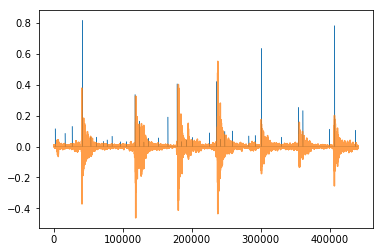

In [157]:
# convert frame pos to sample pos
peaksamp = [peak*hop_length for peak in peaks]

# initialize vector to hold time vector of peaks' placement
peakstimevect = np.zeros(len(y))

print onset_amps
# scale peak by detected onset envelope amplitude
for i, peak in enumerate(peaksamp):
    peakstimevect[peak] = onset_amps[i]

plt.figure() 
plt.plot(peakstimevect, linewidth='0.5')
plt.plot(y, alpha=0.76)
plt.show()
    

In [152]:
# get onset detected peaks in samples
peaksamp = [peak*hop_length for peak in peaks]
# run function to overlay tracked beat onto original track
btaudio = overlaybeats('./samples/woodblock_mono.wav', peaksamp, './audio/nommoslice.wav')


# or use the scaled thresholded version 
#peakscaledamp = [peak*hop_length for peak in ]
#btaudio = overlaybeats('./samples/woodblock_mono.wav', peaksamp, './audio/nommoslice.wav')


sr:44100, srsource:44100
length of ysamp: 19097
window length, 460097
here
2048 21145
16384 35481
26624 45721
41472 60569
53760 72857
61952 81049
71680 90777
77312 96409
84480 103577
96256 115353
105472 124569
117760 136857
124416 143513
130560 149657
137216 156313
152064 171161
165376 184473
178688 197785
184832 203929
192512 211609
200704 219801
225792 244889
235520 254617
241664 260761
247808 266905
258560 277657
282624 301721
291840 310937
301056 320153
329728 348825
354816 373913
360960 380057
399360 418457
407040 426137
437248 456345


In [146]:
def overlaybeats(samplepath, framepattern, sourcepath):
    #print framepattern
    [ysamp, sr] = librosa.load(samplepath, offset=0,sr=44100)
    [ysource, srsource] = librosa.load(sourcepath, offset=0, duration=dur,sr=44100) 
    print "sr:%r, srsource:%r"%(sr,srsource)
    
    if srsource != sr:
        print 'sample rates of source and sample are not the same!'
    
    sampsz = len(ysamp)
    print 'length of ysamp:', sampsz
    sourcesz = len(ysource)
    
    window = np.array(ysource)
    window = np.concatenate((window,np.zeros(sampsz)))
    print 'window length,', len(window)
    
    print 'here'
    for i,samp in enumerate(framepattern):
        #print frame
        print samp, samp + sampsz
        #print onset_amps[frame]
        #print window[frame:(frame+sampsz)]
        window[samp:(samp+sampsz)] = window[samp:(samp+sampsz)] + onset_amps[i]*ysamp
        #print (window[frame:(frame+sampsz)] + ysamp)
      
    return window

In [84]:
print len(peaksamp)
print len(onset_amps)


35
862


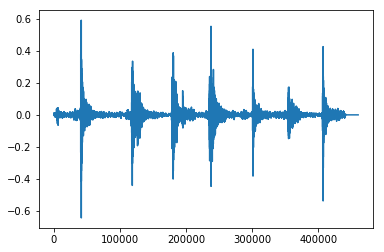

In [106]:

plt.figure() 
plt.plot(btaudio) 
plt.show()

In [153]:
# write out wav file
librosa.output.write_wav('./beataudio/overlay-nommoslice.wav', btaudio, sr=44100)



In [154]:
!open -a Audacity ./beataudio/overlay-nommoslice.wav

In [ ]:
# function to mix learned beat pattern to source audio file
def overlaybeat(samplepath, beatpattern, sourcepath):
    stepinsamp = 22050 # 0.5 sec  grid window for testing (dellis uses 4 ms)
    [ysamp, sr] = librosa.load(samplepath, offset=0)
    dur = len(ysamp)/sr
    print dur
    [ysource, srsource] = librosa.load(sourcepath, offset=0, duration=dur)
    
    if srsource != sr:
        print 'sample rates of source and sample are not the same!'
               
    sampsz = len(ysamp)
    sourcesz = len(ysource)
    #window = np.zeros((beatpattern.shape[0], beatpattern.shape[1]*sr))
    window = np.array([ysource,ysource])

    print window.shape
       
        
    for i in range(beatpattern.shape[0]):
        print beatpattern[i]
        for j in range(beatpattern.shape[1]):
            print 'beatpattern[%r][%r]: %r' %(i,j, beatpattern[i][j])
            if beatpattern[i][j] == 1:
                window[i][(j*sr):(j*sr)+sampsz] = ysamp + ysource[j*sr:(j*sr)+sampsz]
            elif beatpattern[i][j] == 0:
                window[i][(j*sr):(j*sr)+sampsz] = ysource[j*sr:(j*sr)+sampsz]
    return window


# # function to mix learned beat pattern to source audio file
# def overlaybeat(path, beatpattern, sourcepath):
#     stepinsamp = 22050 # 0.5 sec  grid window for testing (dellis uses 4 ms)
#     [ysamp, sr] = librosa.load(path, offset=0)
#     dur = len(ysamp)/sr
#     print dur
#     [ysource, srsource] = librosa.load(sourcepath, offset=0, duration=10)
    
#     if srsource != sr:
#         print 'sample rates of source and sample are not the same!'
               
#     sampsz = len(ysamp)
#     sourcesz = len(ysource)
#     #window = np.zeros((beatpattern.shape[0], beatpattern.shape[1]*sr))
#     window = np.array([ysource,ysource])

#     print window.shape
                  
#     for i in range(beatpattern.shape[0]):
#         print beatpattern[i]
#         for j in range(beatpattern.shape[1]):
#             print 'beatpattern[%r][%r]: %r' %(i,j, beatpattern[i][j])
#             if beatpattern[i][j] == 1:
#                 window[i][(j*sr):(j*sr)+sampsz] = ysamp + ysource[j*sr:(j*sr)+sampsz]
#             elif beatpattern[i][j] == 0:
#                 window[i][(j*sr):(j*sr)+sampsz] = ysource[j*sr:(j*sr)+sampsz]
#     return window

